## Kelompok

### Lynberd stevano dima - 22220125     
### Nathanael Sean Lim - 212200160   
### Reinier Mika Kumala - 202000167


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam

In [2]:
# Load and preprocess data
def load_and_preprocess_data(file_path):
    # Read CSV with proper decimal and thousands separators
    df = pd.read_csv(file_path, decimal=',', thousands='.')

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Handle missing values
    df = df.interpolate(method='time')

    return df
# Load dataset
file_path = "/kaggle/input/quality-prediction-in-a-mining-process/MiningProcess_Flotation_Plant_Database.csv"  # Ganti dengan path dataset Anda
data = pd.read_csv(file_path, delimiter=",", decimal=",")
data = data[:50000]
df = load_and_preprocess_data(file_path)

# Konversi kolom 'date' menjadi tipe datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Urutkan berdasarkan waktu
data.sort_values('date', inplace=True)

# Ganti koma desimal menjadi titik (jika diperlukan)
data.replace(',', '.', regex=True, inplace=True)

# Define features and target
target = '% Silica Concentrate'
features = [col for col in data.columns if col != target]

# Ubah kolom numerik ke tipe float
for col in data.columns[1:]:
    data[col] = data[col].astype(float)

# Tampilan data setelah preprocessing
print(data.head())


                   date  % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
0   2017-03-10 01:00:00         55.2          16.98      3019.53     557.434   
111 2017-03-10 01:00:00         55.2          16.98      3185.55     586.182   
112 2017-03-10 01:00:00         55.2          16.98      3182.03     595.947   
113 2017-03-10 01:00:00         55.2          16.98      3180.86     600.464   
114 2017-03-10 01:00:00         55.2          16.98      1272.66     594.971   

     Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  \
0          395.713      10.0664           1.74000   
111        404.648      10.1139           1.73614   
112        407.168      10.1135           1.73545   
113        402.598      10.1130           1.73476   
114        393.516      10.1125           1.73407   

     Flotation Column 01 Air Flow  Flotation Column 02 Air Flow  ...  \
0                         249.214                       253.235  ...   
111                       250.488                       

In [3]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Assuming 'data' is a Pandas DataFrame
features = data.columns[1:-2]
target = '% Silica Concentrate'

# Normalisasi data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
data[target] = scaler.fit_transform(data[[target]])

# Fungsi untuk membuat data time-series
def create_sequences(data, feature_cols, target_col, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[feature_cols].iloc[i:i + time_steps].values)
        y.append(data[target_col].iloc[i + time_steps])
    return np.array(X), np.array(y)

# Membuat data sequence
time_steps = 24
X, y = create_sequences(data, features, target, time_steps)

# Split data into training and testing sets
ts_split = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in ts_split.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

# Convert to TensorFlow tensors for GPU usage
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

# Print to check if tensors are correctly converted
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (49976, 24, 21), y shape: (49976,)


In [4]:
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model

# Generator Model
latent_dim = 100  # Dimension of the random noise vector
time_steps, features = X.shape[1], X.shape[2]

generator_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(generator_input)
x = RepeatVector(time_steps)(x)
x = LSTM(128, return_sequences=True, activation='relu')(x)
x = LSTM(64, return_sequences=True, activation='relu')(x)
generator_output = TimeDistributed(Dense(features))(x)

generator = Model(generator_input, generator_output, name="Generator")
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 21)         │         1,365 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,285 (762.83 KB)

 Trainable params: 195,285 (762.83 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.layers import Flatten

# Discriminator Model
discriminator_input = Input(shape=(time_steps, features))
x = LSTM(64, return_sequences=True)(discriminator_input)
x = LSTM(32)(x)
x = Dense(128, activation='relu')(x)
discriminator_output = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, discriminator_output, name="Discriminator")
discriminator.compile(optimizer=Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 21)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,785 (151.50 KB)

 Trainable params: 38,785 (151.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.models import Model

discriminator.trainable = True
gan_input = Input(shape=(latent_dim,))
generated_sequence = generator(gan_input)
gan_output = discriminator(generated_sequence)

gan = Model(gan_input, gan_output, name="GAN")
gan.compile(optimizer=Adam(learning_rate=0.02), loss='binary_crossentropy')
gan.summary()

Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Functional)          │ (None, 24, 21)         │       195,285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Functional)      │ (None, 1)              │        38,785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,070 (914.34 KB)

 Trainable params: 234,070 (914.34 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import numpy as np
import tensorflow as tf

# Ensure X is a TensorFlow tensor
X = tf.convert_to_tensor(X, dtype=tf.float32)

# Training Parameters
epochs = 200
batch_size = 32
half_batch = batch_size // 2

latent_dim = 100  # Size of the random noise vector

gen = 1

for epoch in range(epochs):
    # 1. Train the Discriminator
    # Sample real sequences
    idx = np.random.randint(0, X.shape[0], half_batch)
    idx = tf.convert_to_tensor(idx, dtype=tf.int32)  # Convert indices to TensorFlow tensor
    real_sequences = tf.gather(X, idx)

    # Generate fake sequences
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    fake_sequences = generator.predict(noise)
    fake_sequences = tf.convert_to_tensor(fake_sequences, dtype=tf.float32) 

    # Real and fake labels
    real_labels = np.ones((half_batch, 1))  # Labels for real sequences
    fake_labels = np.zeros((half_batch, 1))  # Labels for fake sequences

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_sequences, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 2. Train the Generator
    # Generate noise for the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))  # Labels to trick the discriminator
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress
    gen += 1
    if gen % 10 == 0:
      print(epoch,' D Loss :', d_loss[0], 'acc : ', d_loss[1], '%',' G Loss :', g_loss)

I0000 00:00:1733983715.139109      94 service.cc:145] XLA service 0x5683401003c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733983715.139156      94 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733983715.139159      94 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1733983716.046610      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8  D Loss : 0.46525556 acc :  0.6747345 %  G Loss : [array(0.46553284, dtype=float32), array(0.46553284, dtype=float32), array(0.6840278, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18  D Loss : 0.31705022 acc :  0.84830636 %  G Loss : [array(0.31668255, dtype=float32), array(0.31668255, dtype=float32), array(0.8503289, dtype=float32)]
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


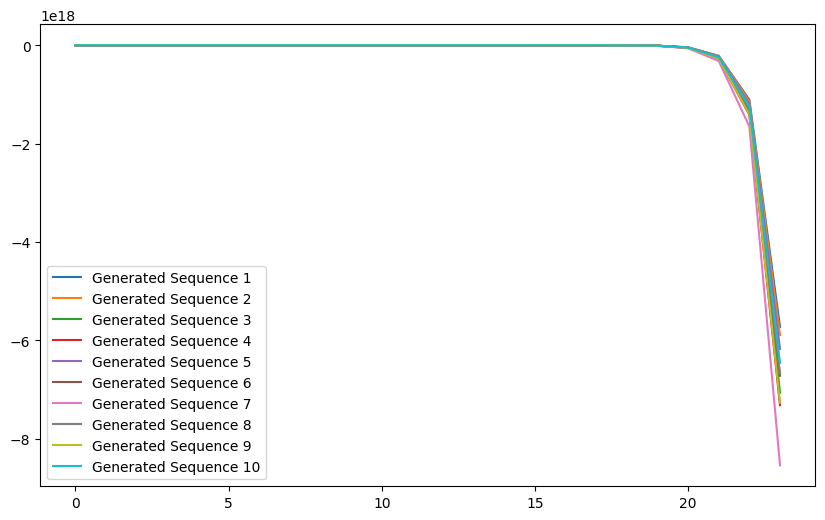

In [47]:
# Generate new sequences
num_samples = 10
noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_sequences = generator.predict(noise)

# Plot generated sequences
plt.figure(figsize=(10, 6))
for i, seq in enumerate(generated_sequences):
    plt.plot(seq[:, 0], label=f"Generated Sequence {i+1}")
plt.legend()
plt.show()

Shape of real_sequences: (10, 22)
Shape of selected generated_sequences: (10, 22)


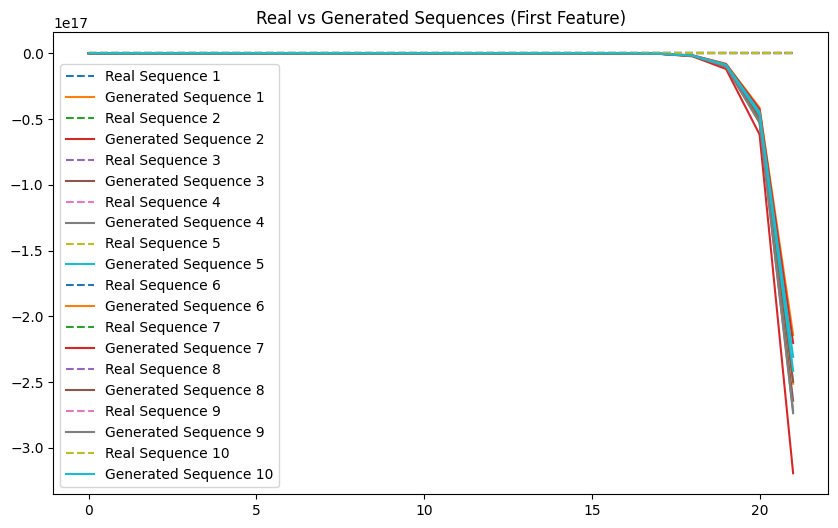

In [53]:
import matplotlib.pyplot as plt

# Select the first feature across all timesteps in generated_sequences
generated_sequences_feature = generated_sequences[:, :, 0]

# Ensure that generated_sequences_feature has the same length as real_sequences (22 timesteps)
generated_sequences_feature = generated_sequences_feature[:, :22]

# Print the shapes for both real_sequences and generated_sequences_feature
print("Shape of real_sequences:", real_sequences.shape)
print("Shape of selected generated_sequences:", generated_sequences_feature.shape)

# Plot real vs generated sequences
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    plt.plot(real_sequences[i], label=f"Real Sequence {i+1}", linestyle='--')
    plt.plot(generated_sequences_feature[i], label=f"Generated Sequence {i+1}")
plt.legend()
plt.title("Real vs Generated Sequences (First Feature)")
plt.show()


Shape of real_sequences: (10, 22)
Shape of selected generated_sequences: (10, 22)
Shape of combined_sequences: (20, 22)


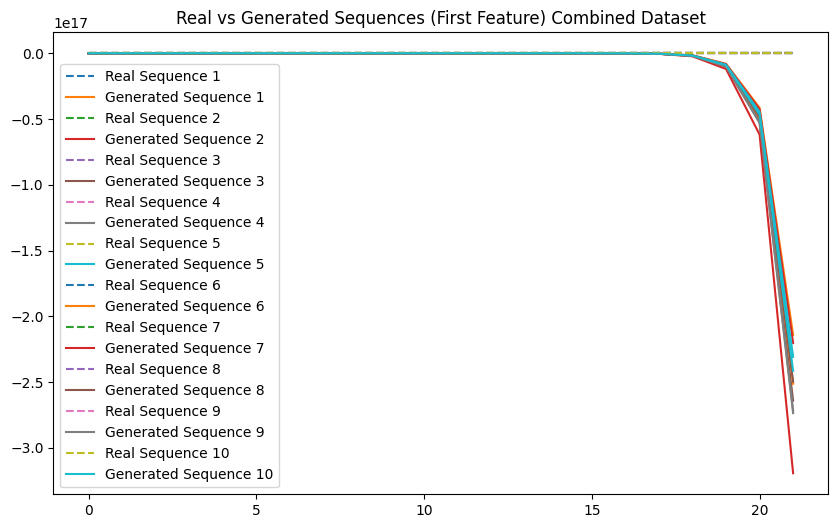

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Select the first feature across all timesteps in generated_sequences
generated_sequences_feature = generated_sequences[:, :, 0]

# Ensure that generated_sequences_feature has the same length as real_sequences (22 timesteps)
generated_sequences_feature = generated_sequences_feature[:, :22]

# Combine real_sequences and generated_sequences_feature into one dataset
combined_sequences = np.concatenate([real_sequences, generated_sequences_feature], axis=0)

# Print the shapes for both real_sequences and generated_sequences_feature after concatenation
print("Shape of real_sequences:", real_sequences.shape)
print("Shape of selected generated_sequences:", generated_sequences_feature.shape)
print("Shape of combined_sequences:", combined_sequences.shape)

# Plot real vs generated sequences as one combined dataset
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    # Plot real sequences (first half of combined dataset)
    plt.plot(combined_sequences[i], label=f"Real Sequence {i+1}", linestyle='--')
    # Plot generated sequences (second half of combined dataset)
    plt.plot(combined_sequences[num_samples + i], label=f"Generated Sequence {i+1}")
plt.legend()
plt.title("Real vs Generated Sequences (First Feature) Combined Dataset")
plt.show()


Shape of real_sequences: (10, 22)
Shape of selected generated_sequences: (10, 22)
Shape of combined_sequences: (20, 22)


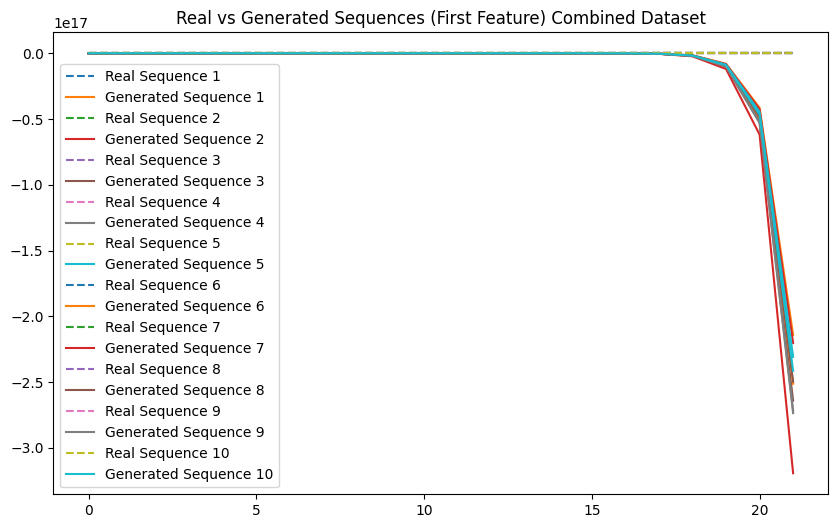

Epoch [10/100], Loss: 116820310502387760637103147319296.0000
Epoch [20/100], Loss: 116820310502387760637103147319296.0000
Epoch [30/100], Loss: 116820310502387760637103147319296.0000
Epoch [40/100], Loss: 116748809793712473009194325245952.0000
Epoch [50/100], Loss: 116748809793712473009194325245952.0000
Epoch [60/100], Loss: 116748809793712473009194325245952.0000
Epoch [70/100], Loss: 116714118458392811610396956819456.0000
Epoch [80/100], Loss: 116714118458392811610396956819456.0000
Epoch [90/100], Loss: 116714118458392811610396956819456.0000
Epoch [100/100], Loss: 116714118458392811610396956819456.0000
Mean Squared Error: 31402395508045973529707115708416.00
R-squared: -606946533936082922220503370301440.00


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Select the first feature across all timesteps in generated_sequences
generated_sequences_feature = generated_sequences[:, :, 0]

# Ensure that generated_sequences_feature has the same length as real_sequences (22 timesteps)
generated_sequences_feature = generated_sequences_feature[:, :22]

# Combine real_sequences and generated_sequences_feature into one dataset
combined_sequences = np.concatenate([real_sequences, generated_sequences_feature], axis=0)

# Print the shapes for both real_sequences and generated_sequences_feature after concatenation
print("Shape of real_sequences:", real_sequences.shape)
print("Shape of selected generated_sequences:", generated_sequences_feature.shape)
print("Shape of combined_sequences:", combined_sequences.shape)

# Plot real vs generated sequences as one combined dataset
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    # Plot real sequences (first half of combined dataset)
    plt.plot(combined_sequences[i], label=f"Real Sequence {i+1}", linestyle='--')
    # Plot generated sequences (second half of combined dataset)
    plt.plot(combined_sequences[num_samples + i], label=f"Generated Sequence {i+1}")
plt.legend()
plt.title("Real vs Generated Sequences (First Feature) Combined Dataset")
plt.show()

# Prepare the target variable (y) - Replace with actual target values
# For demonstration, using random values as placeholders
y_combined = np.random.rand(combined_sequences.shape[0], 1)  # Replace with actual target values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_sequences, y_combined, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the neural network model (simple feedforward model)
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)  # First hidden layer
        self.layer2 = nn.Linear(64, 32)         # Second hidden layer
        self.layer3 = nn.Linear(32, 1)          # Output layer
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]  # Number of timesteps in each sequence
model = SimpleNN(input_dim)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

# Call this function after model creation
initialize_weights(model)


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    
    # Move data to GPU if available
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Make predictions on the test set
model.eval()
X_test_tensor = X_test_tensor.to(device)
y_pred_tensor = model(X_test_tensor).cpu().detach().numpy()


print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")


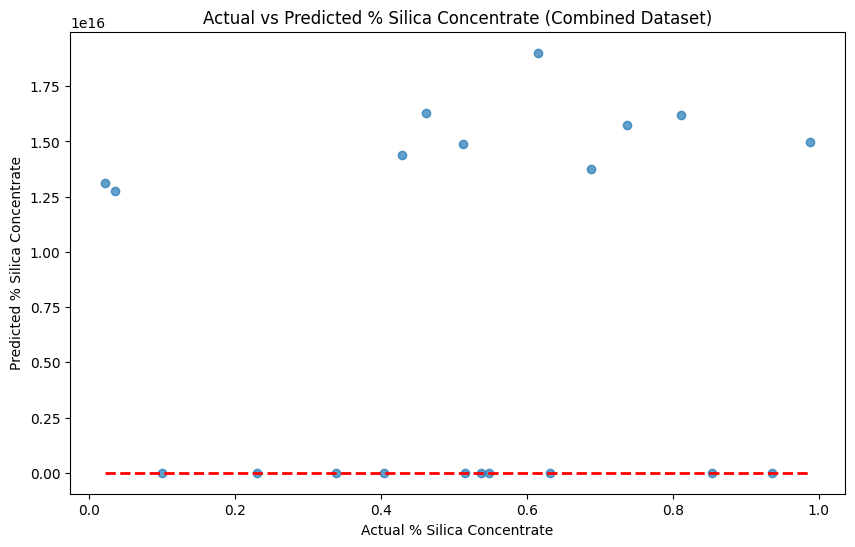

Mean Squared Error (Combined Dataset): 115627368557499447331138612232192.00
R-squared (Combined Dataset): -1555713672402973821475002865680384.00


In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the combined dataset (real + generated sequences)
model.eval()
X_combined_tensor = torch.tensor(combined_sequences, dtype=torch.float32).to(device)
y_pred_combined_tensor = model(X_combined_tensor).cpu().detach().numpy()

# Assuming y_combined contains the actual target values for the combined dataset
# Plot actual vs predicted values for the combined dataset
plt.figure(figsize=(10, 6))
plt.scatter(y_combined, y_pred_combined_tensor, alpha=0.7)
plt.plot([y_combined.min(), y_combined.max()], [y_combined.min(), y_combined.max()], 'r--', linewidth=2)
plt.title('Actual vs Predicted % Silica Concentrate (Combined Dataset)')
plt.xlabel('Actual % Silica Concentrate')
plt.ylabel('Predicted % Silica Concentrate')
plt.show()

# Evaluate the model on the combined dataset
mse_combined = mean_squared_error(y_combined, y_pred_combined_tensor)
r2_combined = r2_score(y_combined, y_pred_combined_tensor)

print(f"Mean Squared Error (Combined Dataset): {mse_combined:.2f}")
print(f"R-squared (Combined Dataset): {r2_combined:.2f}")
